In [1]:
import embeddings
import custom_tools

# Read json file
job_id = "VojrEHdFRPUTsJ3zGTiPcQ"
args  = custom_tools.load_json(f"../models/selected_models/{job_id}.json")
args["num_node_features"] = 33
deg = custom_tools.load_pickle(f"../models/selected_models/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = "../models/selected_models", model_type = "SD", args = args, deg=deg)

print(model)

Global seed set to 42


CPU is available on this device!
CustomGCN(
  (convs): ModuleList(
    (0): PNAConv(33, 32, towers=1, edge_dim=None)
    (1-2): 2 x PNAConv(32, 32, towers=1, edge_dim=None)
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ff_layers): ModuleList(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
  (ff_batch_norms): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [2]:
from dataset import TissueDataset
import os

dataset = TissueDataset(os.path.join("../data/JacksonFischer", "month"),  "month")

Global seed set to 42


Target prediction: OSmonth


In [3]:
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)

In [4]:
emd512 = emd[0]


In [5]:
emd512.shape

torch.Size([752, 512])

/opt/homebrew/Caskroom/miniconda/base/envs/COPred_2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/COPred_2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/bas

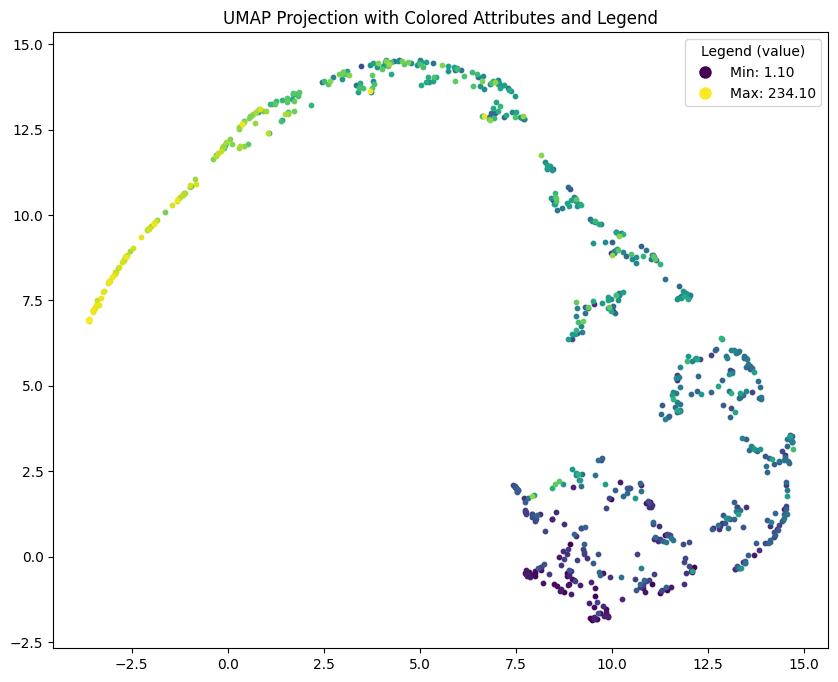

In [6]:
import plotting

plotting.UMAP_plot(emd512, related_data, 'y')


In [7]:

emd_mp, related_data_mp = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1, mode="CNV")

In [8]:
len(emd_mp)

3

In [9]:
MS_L0 = emd_mp[0]
MS_L1 = emd_mp[1]
MS_L2 = emd_mp[2]

In [10]:
# Get mean of the columns for MS_LX
MS_L2.shape

torch.Size([752, 32])

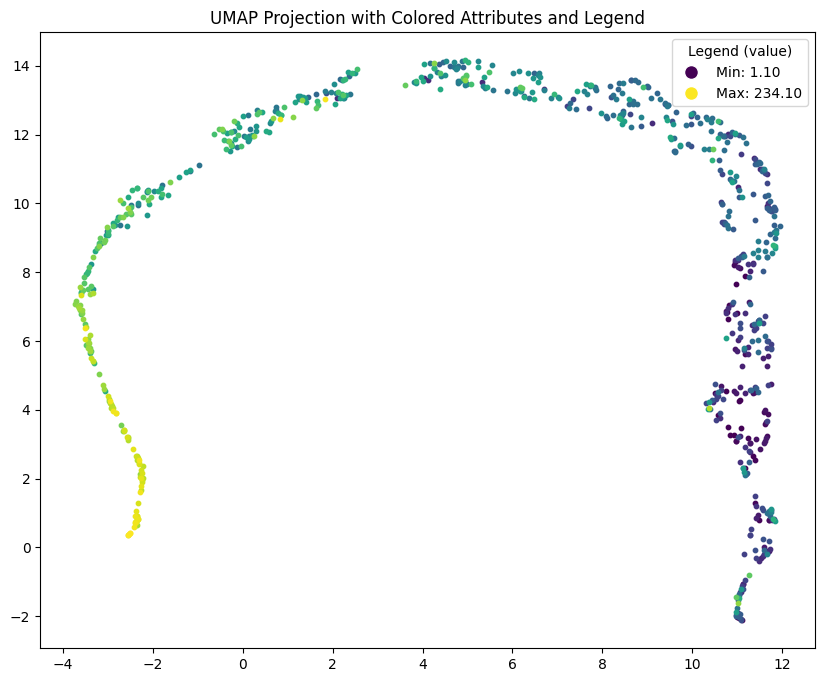

In [11]:
import plotting

plotting.UMAP_plot(MS_L2, related_data_mp, 'y')


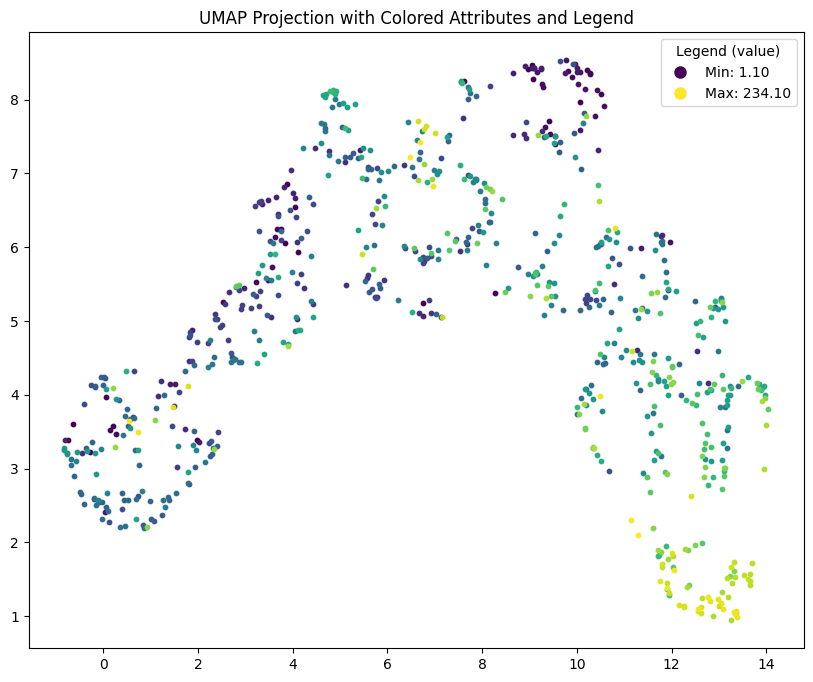

In [12]:
plotting.UMAP_plot(MS_L1, related_data_mp, 'y')

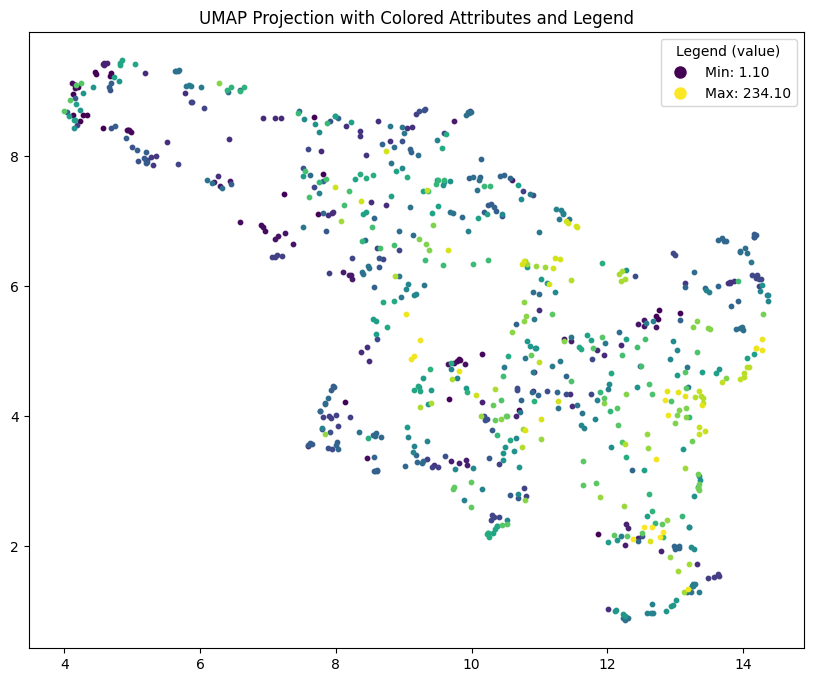

In [13]:
plotting.UMAP_plot(MS_L0, related_data_mp, 'y')

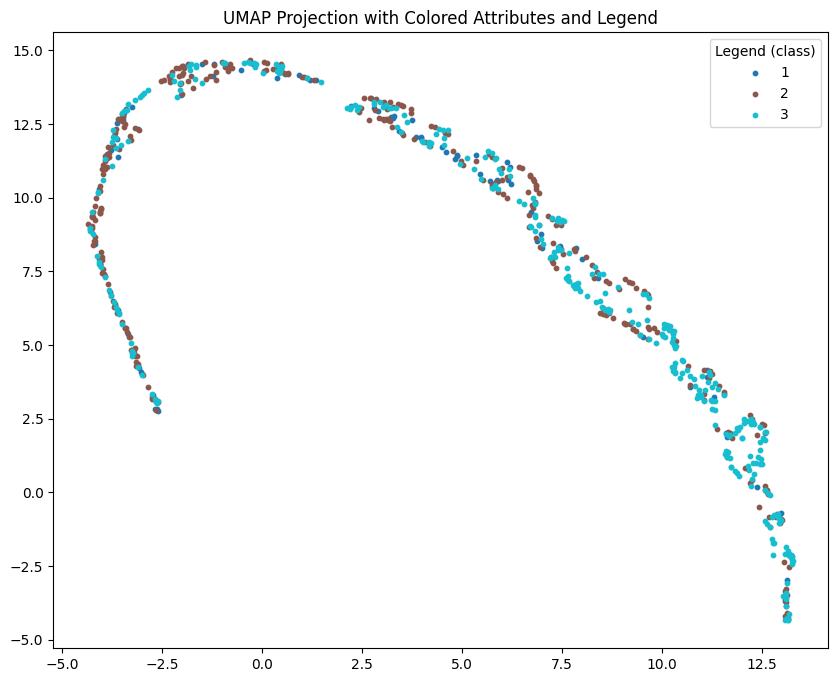

In [14]:
plotting.UMAP_plot(MS_L2, related_data_mp, 'tumor_grade')

In [15]:
import numpy as np

# Find the first quantile of the OSmonth, related_data_mp is list of batches
osmonth = np.array([item.osmonth.item() for item in related_data_mp])

# Remove samples with OSmonth > 0.25 quantile, from both related_data_mp and emd512
osmonth = np.array([item.osmonth.item() for item in related_data_mp])
inds = np.where(osmonth > np.quantile(osmonth, 0.25))
osmonth = np.delete(osmonth, inds)

emd512_filtered = np.delete(emd512, inds, axis=0)




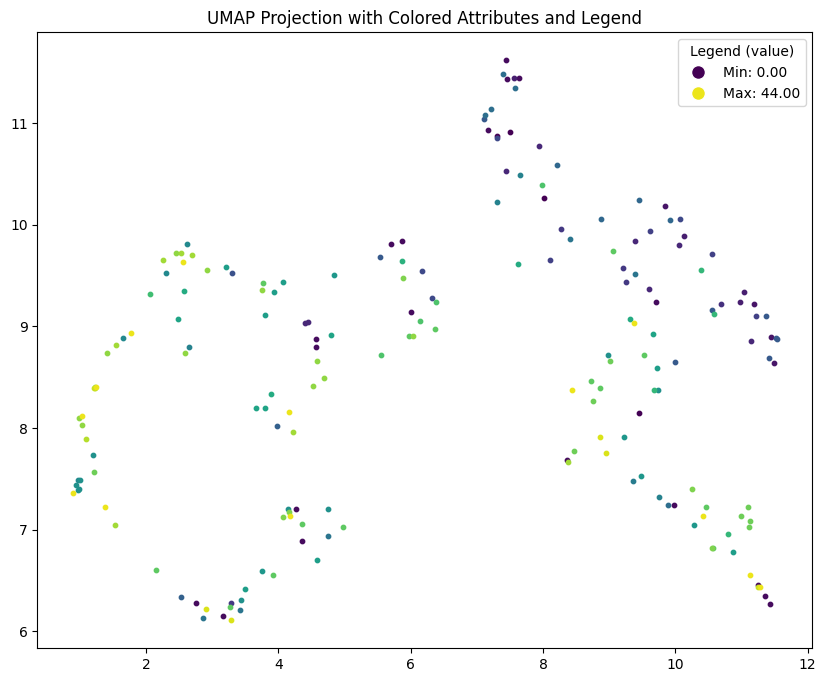

In [16]:
import plotting

plotting.UMAP_plot(emd512_filtered, related_data, 'y',attributes = osmonth)


/opt/homebrew/Caskroom/miniconda/base/envs/COPred_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


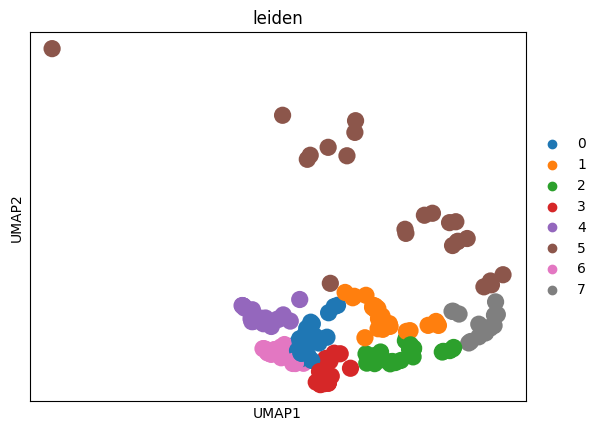

In [38]:
# Cluster emd512 with leiden
import leidenalg
import scanpy as sc
import umap

# emd512 to ndarray
emd512_filtered = np.array(emd512_filtered)



adata = sc.AnnData(emd512_filtered)

# Record y to adata.obs using related_data's y
y = []
for i in range(len(related_data)):
    y.append(related_data[i].y.item())
y = np.array(y)
y = np.delete(y, inds)
adata.obs['y'] = y


embedding_umap = umap.UMAP().fit_transform(emd512)
adata.obsm['umap'] = np.delete(embedding_umap, inds, axis=0)

sc.pp.neighbors(adata, use_rep='X')
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], save = "_leiden_0.25.png")

In [55]:
# Calculate average y for each cluster
cluster_y = []
for i in range(len(np.unique(adata.obs['leiden']))):
    cluster_y.append(np.mean(adata.obs['y'][adata.obs['leiden'] == str(i) ]))
cluster_y

[23.93333333333334,
 24.533333333333342,
 22.635714285714293,
 10.891666666666666,
 27.186956521739138,
 34.83913043478262,
 10.236363636363636,
 30.366666666666678]

In [54]:
a = adata.obs['leiden'] == 0
type(adata.obs['leiden'][1])

str

In [20]:
a = [b.osmonth.item() for b in related_data_mp]
a

[109.0,
 58.0,
 121.0,
 3.0,
 54.0,
 78.0,
 53.0,
 122.0,
 47.0,
 54.0,
 121.0,
 88.0,
 2.0,
 128.0,
 7.0,
 81.0,
 75.0,
 77.0,
 42.0,
 12.0,
 186.0,
 88.0,
 65.0,
 167.0,
 195.0,
 233.0,
 59.0,
 44.0,
 53.0,
 87.0,
 102.0,
 10.0,
 150.0,
 95.0,
 76.0,
 21.0,
 113.0,
 23.0,
 121.0,
 1.0,
 127.0,
 172.0,
 63.0,
 87.0,
 63.0,
 143.0,
 180.0,
 33.0,
 36.0,
 15.0,
 16.0,
 68.0,
 59.0,
 107.0,
 98.0,
 97.0,
 41.0,
 63.0,
 74.0,
 70.0,
 93.0,
 67.0,
 73.0,
 89.0,
 4.0,
 54.0,
 115.0,
 180.0,
 22.0,
 179.0,
 75.0,
 35.0,
 58.0,
 79.0,
 18.0,
 99.0,
 46.0,
 33.0,
 58.0,
 102.0,
 1.0,
 59.0,
 61.0,
 1.0,
 166.0,
 135.0,
 63.0,
 141.0,
 195.0,
 58.0,
 65.0,
 123.0,
 58.0,
 95.0,
 141.0,
 38.0,
 63.0,
 178.0,
 181.0,
 23.0,
 55.0,
 110.0,
 4.0,
 171.0,
 12.0,
 143.0,
 84.0,
 39.0,
 77.0,
 152.0,
 20.0,
 51.0,
 104.0,
 35.0,
 58.0,
 37.0,
 85.0,
 181.0,
 53.0,
 14.0,
 86.0,
 66.0,
 64.0,
 115.0,
 1.0,
 99.0,
 66.0,
 68.0,
 58.0,
 86.0,
 89.0,
 117.0,
 24.0,
 52.0,
 154.0,
 57.0,
 67.0,
 97.0,
 61.

In [21]:
attributes = [handle_types(getattr(data_batch, attribute_name)) for data_batch in related_data]

NameError: name 'handle_types' is not defined

In [ ]:
a = dataset.y.tolist()

In [ ]:
min(a)

1.1